# Data augmentation & converting labels

## First split into train, validation and test splits

In [2]:
import numpy as np
import cv2
import random
from shutil import copy
from pathlib import Path

In [18]:
images = "raw/images"
labels = "raw/masks"

# Create a list of all image files
image_files = list(Path(images).glob("*.png"))

# print(len(image_files)) #1080
# Shuffle the image files
random.shuffle(image_files)

# Split into train, validation, and test sets
valid_files = image_files[0:108]
test_files = image_files[108:216]
train_files = image_files[216:]

# Define output directories
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

train_mask_dir = "train_mask"
valid_mask_dir = "valid_mask"
test_mask_dir = "test_mask"

# Create directories if they don't exist
Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(valid_dir).mkdir(parents=True, exist_ok=True)
Path(test_dir).mkdir(parents=True, exist_ok=True)


Path(train_mask_dir).mkdir(parents=True, exist_ok=True)
Path(valid_mask_dir).mkdir(parents=True, exist_ok=True)
Path(test_mask_dir).mkdir(parents=True, exist_ok=True)

# copy the files from raw/images into correspoding train valid and test folders. Move the masks too

for file_set, output_dir, output_mask_dir in zip(
    [train_files, valid_files, test_files],
    [train_dir, valid_dir, test_dir],
    [train_mask_dir, valid_mask_dir, test_mask_dir]
):
    for file_path in file_set:
        # Copy image file
        dest_image_path = Path(output_dir) / file_path.name
        copy(file_path, dest_image_path)

        # Copy corresponding mask file
        mask_file_path = Path(labels) / file_path.name
        dest_mask_path = Path(output_mask_dir) / file_path.name
        if mask_file_path.exists():
            copy(mask_file_path, dest_mask_path)

## Augment the data to account for rotations

In [3]:
import albumentations as A
import cv2
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Define the augmentation pipeline
def create_train_augmentation_pipeline():
    transform = A.Compose([
        # Apply random rotation (up to 60 degrees) and translation
        # A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0),

        A.Affine(scale=(1, 0.9), p=0.3 ),
        # Apply random rotation up to 45 degrees
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=90, p=0.7),  # p=1.0 ensures rotation is always applied[3]
        A.VerticalFlip(p=0.2),
        # Take a random 640x480 crop
        A.RandomCrop(height=480, width=640, p=1.0),
        A.RandomBrightnessContrast(
        brightness_limit=0.3,     # Handle darker/brighter conditions
        contrast_limit=0.2,
        p=0.4
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,       # Slight color temperature changes
        sat_shift_limit=20,
        val_shift_limit=20,
        p=0.4
    ),
    A.RandomGamma(
        gamma_limit=(70, 130),    # Gamma correction for different exposures
        p=0.4
    ),

    ])
    
    return transform

def create_test_augmentation_pipeline():
    transform = A.Compose([
        # Apply random rotation (up to 60 degrees) and translation
        # A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0),

        A.Affine(scale=(1, 0.9), p=0.3 ),
        # Apply random rotation up to 45 degrees
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=60, p=0.7),  # p=1.0 ensures rotation is always applied[3]
        A.VerticalFlip(p=0.1),
        # Take a random 640x480 crop
        A.RandomCrop(height=480, width=640, p=1.0),

        A.RandomBrightnessContrast(
        brightness_limit=0.3,     # Handle darker/brighter conditions
        contrast_limit=0.2,
        p=0.3
    ),

    ])
    
    return transform

# Function to process a pair of image and mask
def process_image_pair(image_path, mask_path, output_dir, output_mask_dir, num_augmentations=6):
    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Read mask without color conversion

    # image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
    
    # print(image.shape)
    # Print unique values in the mask
    # unique_values = np.unique(mask)
    # print(f"Unique values in the mask: {unique_values}")

    
    
    # Check if image and mask were loaded properly
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    if mask is None:
        print(f"Error: Could not load mask at {mask_path}")
        return
    
    # Calculate the width of each vertical part
    part_height = 1280 // 2  
    
    # Split the image into two vertical parts
    parts = [
        image[0:part_height :, :],
        image[part_height:, :, :],
    ]

    mask_parts = [
        mask[0:part_height :],
        mask[part_height:, :],
    ]
    
    # # Check image dimensions
    # h, w = image.shape[:2]
    # # print(h, w)
    # h_mask, w_mask = mask.shape[:2]
    
    # if h < 480 or w < 640:
    #     print(f"Warning: Image {image_path} is smaller than the target crop size ({w}x{h})")
    #     return
    
    # if h_mask != h or w_mask != w:
    #     print(f"Warning: Mask dimensions ({w_mask}x{h_mask}) don't match image dimensions ({w}x{h})")
    #     return
    
    # Get the image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Create the augmentation pipeline
    transform = create_test_augmentation_pipeline()

    for i in range(num_augmentations):
        for j in range(2):
            img_part = parts[j]
            # print(img_part[i].shape)
            mask_part = mask_parts[j]
            # print(img_part.shape)
            augmented = transform(image=img_part, mask=mask_part)
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']

            # Save the augmented image and mask
            output_path = os.path.join(output_dir, f"{image_name}_augment_{j}_{i}.jpg")
            output_mask_path = os.path.join(output_mask_dir, f"{image_name}_augment_{j}_{i}_mask.png")

            cv2.imwrite(output_path, augmented_image)
            cv2.imwrite(output_mask_path, augmented_mask)

/home/vader/anaconda3/envs/perception/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [16]:
# Define input and output directories
input_dir = "train/"     
mask_dir = "train_mask/"       
output_dir = "augmentations/train/"  
output_mask_dir = "augmentations/train_mask/"  

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Get all images in the input directory
image_paths = glob(os.path.join(input_dir, "*.png"))

# Process each image and its corresponding mask
for image_path in image_paths:
    # Determine the corresponding mask path based on your naming convention
    # This example assumes masks have the same name but are in the mask_dir directory
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    # image_base = image_name.replace("_color", "")
    mask_path = os.path.join(mask_dir, f"{image_name}.png") 
    
    # Check if the mask exists
    if not os.path.exists(mask_path):
        print(f"Warning: No corresponding mask found for {mask_path}")
        continue
    
    # Process the image-mask pair
    process_image_pair(image_path, mask_path, output_dir, output_mask_dir, 8)

print(f"Processed {len(image_paths)} images and their masks")

Processed 864 images and their masks


In [18]:
input_dir = "valid/"     
mask_dir = "valid_mask/"       
output_dir = "augmentations/valid/"  
output_mask_dir = "augmentations/valid_mask/"  

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Get all images in the input directory
image_paths = glob(os.path.join(input_dir, "*.png"))

# Process each image and its corresponding mask
for image_path in image_paths:
    # Determine the corresponding mask path based on your naming convention
    # This example assumes masks have the same name but are in the mask_dir directory
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    # image_base = image_name.replace("_color", "")
    mask_path = os.path.join(mask_dir, f"{image_name}.png") 
    
    # Check if the mask exists
    if not os.path.exists(mask_path):
        print(f"Warning: No corresponding mask found for {mask_path}")
        continue
    
    # Process the image-mask pair
    process_image_pair(image_path, mask_path, output_dir, output_mask_dir, 6)

print(f"Processed {len(image_paths)} images and their masks")

Processed 108 images and their masks


In [19]:
input_dir = "test/"     
mask_dir = "test_mask/"       
output_dir = "augmentations/test/"  
output_mask_dir = "augmentations/test_mask/"  

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Get all images in the input directory
image_paths = glob(os.path.join(input_dir, "*.png"))

# Process each image and its corresponding mask
for image_path in image_paths:
    # Determine the corresponding mask path based on your naming convention
    # This example assumes masks have the same name but are in the mask_dir directory
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    # image_base = image_name.replace("_color", "")
    mask_path = os.path.join(mask_dir, f"{image_name}.png") 
    
    # Check if the mask exists
    if not os.path.exists(mask_path):
        print(f"Warning: No corresponding mask found for {mask_path}")
        continue
    
    # Process the image-mask pair
    process_image_pair(image_path, mask_path, output_dir, output_mask_dir, 6)

print(f"Processed {len(image_paths)} images and their masks")

Processed 108 images and their masks


### Generate the YOLO labels from masks

In [4]:
def mask_to_yolo_format(mask):
    """
    Convert an instance segmentation mask to YOLO format
    
    Args:
        mask: numpy array where each unique value > 0 represents an instance
        
    Returns:
        string of YOLO format annotations (class_id, x1, y1, x2, y2, ...)
    """
    height, width = mask.shape
    yolo_annotations = []
    
    # Find unique instance IDs (excluding background 0)
    instance_ids = np.unique(mask)
    instance_ids = instance_ids[instance_ids > 0]
    
    for instance_id in instance_ids:
        # Create binary mask for this instance
        instance_mask = (mask == instance_id).astype(np.uint8)
        
        # Find contours
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            continue
            
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # epsilon = 0.005 * cv2.arcLength(largest_contour, True)
        # approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # # Extract coordinates and normalize
        # points = approx_contour.reshape(-1, 2).astype(float)
        # points[:, 0] /= width  # Normalize x coordinates
        # points[:, 1] /= height  # Normalize y coordinates

        epsilon = 0.005 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Need at least 3 points to define a polygon
        if len(approx) < 3:
            continue

        
        yolo_line = f"{0}"
                
        for point in approx.reshape(-1, 2):
            # Normalize coordinates to [0, 1]
            x_norm = point[0] / width
            y_norm = point[1] / height
            
            # Add to YOLO line
            yolo_line += f" {x_norm:.6f} {y_norm:.6f}"
        
        yolo_annotations.append(yolo_line)
        
    yolo_string = "\n".join(yolo_annotations)
    

    return yolo_string

In [5]:
from pathlib import Path

mask_dir = Path("augmentations/train_mask/")
labels_dir = Path("augmentations/train/")
mask_paths = mask_dir.glob("*.png")

for mask_path in mask_paths:
    img = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    yolo_annotations = mask_to_yolo_format(img)
    
    # Save to file
    base_name = mask_path.stem.replace("_mask", "")
    output_txt_path = labels_dir / f"{base_name}.txt"
    
    labels_dir.mkdir(parents=True, exist_ok=True)  # Ensure the labels directory exists
    with open(output_txt_path, 'w') as f:
        f.write(yolo_annotations)
    print(f"Saved YOLO annotations to {output_txt_path}")


Saved YOLO annotations to augmentations/train/1601540513679025_augment_1_3.txt
Saved YOLO annotations to augmentations/train/1601541725248149_augment_0_3.txt
Saved YOLO annotations to augmentations/train/1601540516342802_augment_1_4.txt
Saved YOLO annotations to augmentations/train/1601541696585622_augment_1_2.txt
Saved YOLO annotations to augmentations/train/1600937314632696_augment_0_7.txt
Saved YOLO annotations to augmentations/train/1600937809881154_augment_1_7.txt
Saved YOLO annotations to augmentations/train/1600937385292021_augment_1_0.txt
Saved YOLO annotations to augmentations/train/1600937709228087_augment_0_7.txt
Saved YOLO annotations to augmentations/train/1600937769885237_augment_1_4.txt
Saved YOLO annotations to augmentations/train/1601540459675002_augment_1_6.txt
Saved YOLO annotations to augmentations/train/1600937414625705_augment_1_4.txt
Saved YOLO annotations to augmentations/train/1600937409299560_augment_1_6.txt
Saved YOLO annotations to augmentations/train/160093

In [8]:
from pathlib import Path

mask_dir = Path("augmentations/valid_mask/")
labels_dir = Path("augmentations/valid/")
mask_paths = mask_dir.glob("*.png")

for mask_path in mask_paths:
    img = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    yolo_annotations = mask_to_yolo_format(img)
    
    # Save to file
    base_name = mask_path.stem.replace("_mask", "")
    output_txt_path = labels_dir / f"{base_name}.txt"
    
    labels_dir.mkdir(parents=True, exist_ok=True)  # Ensure the labels directory exists
    with open(output_txt_path, 'w') as f:
        f.write(yolo_annotations)
    print(f"Saved YOLO annotations to {output_txt_path}")

Saved YOLO annotations to augmentations/valid/1600937368629000_augment_0_0.txt
Saved YOLO annotations to augmentations/valid/1600936861527001_augment_1_4.txt
Saved YOLO annotations to augmentations/valid/1600937795215924_augment_0_5.txt
Saved YOLO annotations to augmentations/valid/1600937327968231_augment_1_0.txt
Saved YOLO annotations to augmentations/valid/1600937318632269_augment_0_1.txt
Saved YOLO annotations to augmentations/valid/1600937701901231_augment_1_5.txt
Saved YOLO annotations to augmentations/valid/1601540419679192_augment_0_5.txt
Saved YOLO annotations to augmentations/valid/1600937403956787_augment_0_2.txt
Saved YOLO annotations to augmentations/valid/1600937741224819_augment_1_1.txt
Saved YOLO annotations to augmentations/valid/1601540405014087_augment_1_3.txt
Saved YOLO annotations to augmentations/valid/1600936878191950_augment_0_4.txt
Saved YOLO annotations to augmentations/valid/1600936940185063_augment_0_0.txt
Saved YOLO annotations to augmentations/valid/160093

In [7]:
from pathlib import Path

mask_dir = Path("augmentations/test_mask/")
labels_dir = Path("augmentations/test/")
mask_paths = mask_dir.glob("*.png")

for mask_path in mask_paths:
    img = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    yolo_annotations = mask_to_yolo_format(img)
    
    # Save to file
    base_name = mask_path.stem.replace("_mask", "")
    output_txt_path = labels_dir / f"{base_name}.txt"
    
    labels_dir.mkdir(parents=True, exist_ok=True)  # Ensure the labels directory exists
    with open(output_txt_path, 'w') as f:
        f.write(yolo_annotations)
    print(f"Saved YOLO annotations to {output_txt_path}")

Saved YOLO annotations to augmentations/test/1601540398348109_augment_1_0.txt
Saved YOLO annotations to augmentations/test/1601540493665805_augment_0_0.txt
Saved YOLO annotations to augmentations/test/1601540145608321_augment_1_4.txt
Saved YOLO annotations to augmentations/test/1601540437677267_augment_0_0.txt
Saved YOLO annotations to augmentations/test/1601540419012586_augment_0_4.txt
Saved YOLO annotations to augmentations/test/1600936881524943_augment_1_5.txt
Saved YOLO annotations to augmentations/test/1601540405680668_augment_1_2.txt
Saved YOLO annotations to augmentations/test/1601540443010073_augment_1_0.txt
Saved YOLO annotations to augmentations/test/1601541636592525_augment_1_0.txt
Saved YOLO annotations to augmentations/test/1600937740557333_augment_1_4.txt
Saved YOLO annotations to augmentations/test/1601540116934785_augment_1_5.txt
Saved YOLO annotations to augmentations/test/1600937359963921_augment_0_1.txt
Saved YOLO annotations to augmentations/test/1600937342629737_au

raw/images/1600936832187439.png


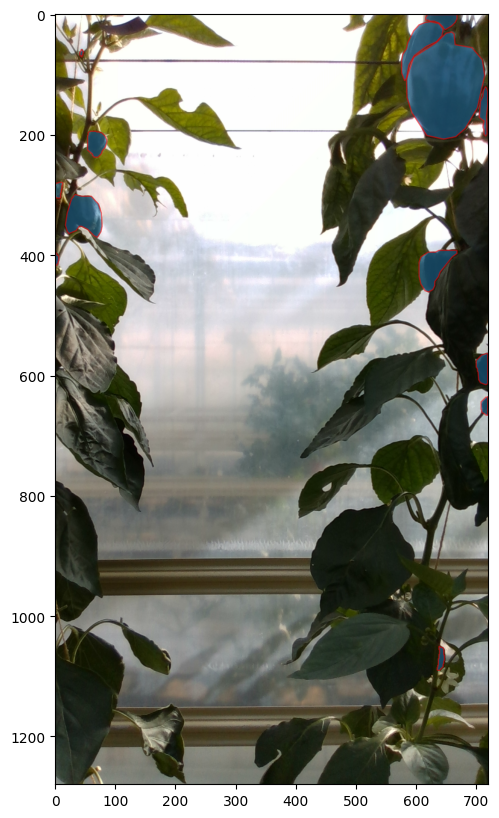

In [ ]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
sample_name = "1600936834860209_augment_0_6.jpg"
mask_path = "raw/masks/" + sample_name + ".png"

img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
yolo_annotations = mask_to_yolo_format(img)

img_path = "raw/images/" + sample_name + ".png"
print(img_path)
image = plt.imread(img_path)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

height = image.shape[0]
width = image.shape[1]

image_shape = np.array([width, height]).reshape((-1,2))

annotation_poly = []

for line in yolo_annotations.split("\n"):
    y = np.array(line.split(" ")[1:]).astype(np.float32)
    annotation_poly.append(y)

for poly in annotation_poly:
    p = Polygon(poly.reshape((-1,2)) * image_shape, edgecolor = 'r', fill = True, alpha=0.5)
    ax.add_patch(p)

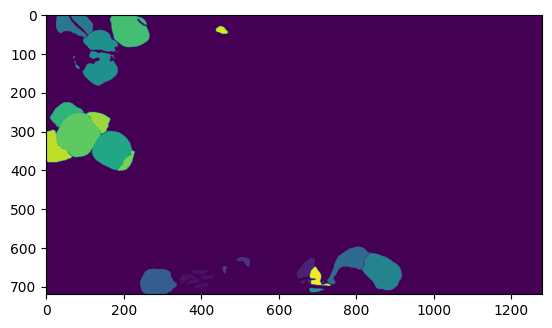

In [2]:
sample_name = "1600936870192809"
mask_path = "raw/masks/" + sample_name + ".png"
img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).T
plt.imshow(img)
plt.show()

KeyboardInterrupt: 

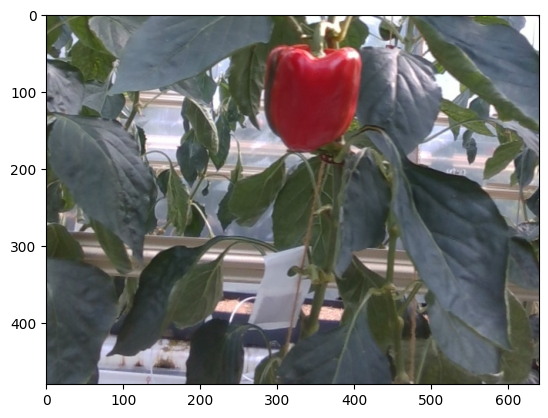

In [5]:
sample_name = "1600937775884646_aug_13"

img_path = "raw/augmentations1/images/" + sample_name + ".jpg"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

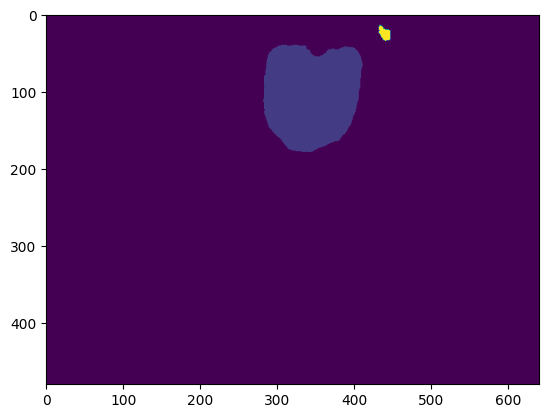

In [6]:
sample_name = "1600937775884646_aug_13"
mask_path = "raw/augmentations1/masks/" + sample_name + "_mask.png"
img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()

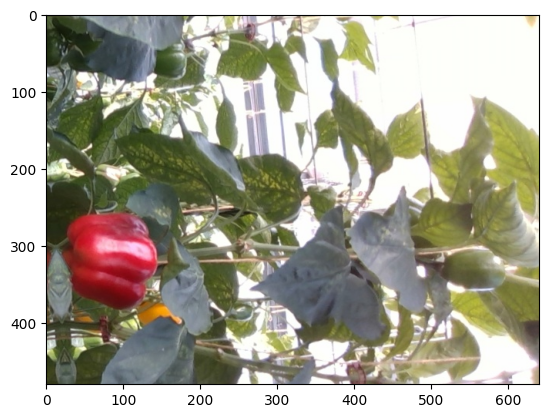

In [42]:
sample_name = "1601541649257702_augment_14"
img_path = "raw/augmentations/images/" + sample_name + ".jpg"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

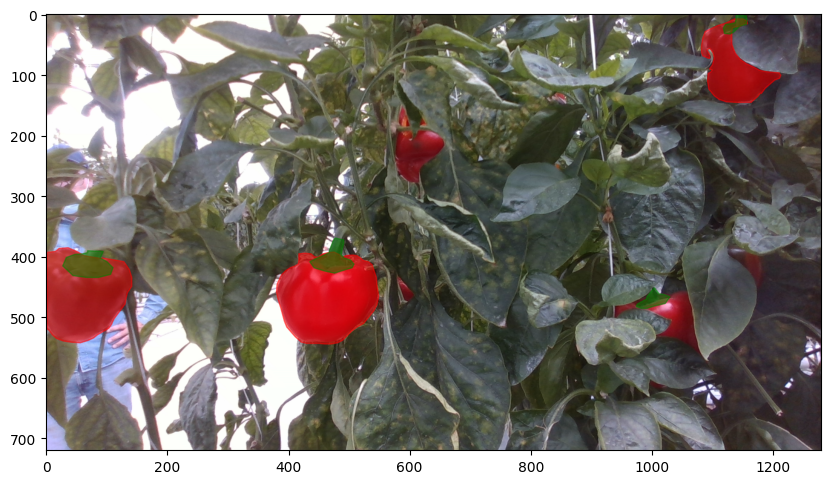

In [15]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_path = "/home/kshitij/Documents/Bell Pepper/dataset-collection/dataset_620_red_yellow_cart_only/_Color_1607625615060.01098632812500.png"
image = plt.imread(img_path)
annotation_path = "/home/kshitij/Documents/Bell Pepper/dataset-collection/labels/_Color_1607625615060.01098632812500.txt"

yolo_annotations = open(annotation_path).read()

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

height = image.shape[0]
width = image.shape[1]

image_shape = np.array([width, height]).reshape((-1,2))

annotation_poly = []
fruit_poly = []
peduncle_poly = []

for line in yolo_annotations.split("\n"):
    # y = np.array(line.split(" ")[1:]).astype(np.float32)
    if line.split(" ")[0] == '0':
        fruit_y = np.array(line.split(" ")[1:]).astype(np.float32)
        fruit_poly.append(fruit_y)
    if line.split(" ")[0] == '1':
        peduncle_y = np.array(line.split(" ")[1:]).astype(np.float32)
        peduncle_poly.append(peduncle_y)
    # annotation_poly.append(y)

for poly in fruit_poly:
    p = Polygon(poly.reshape((-1,2)) * image_shape, facecolor = 'red', edgecolor = 'r',  fill = True, alpha=0.5)
    ax.add_patch(p)

for poly in peduncle_poly:
    p = Polygon(poly.reshape((-1,2)) * image_shape, facecolor = 'green', edgecolor = 'g',  fill = True, alpha=0.5)
    ax.add_patch(p)

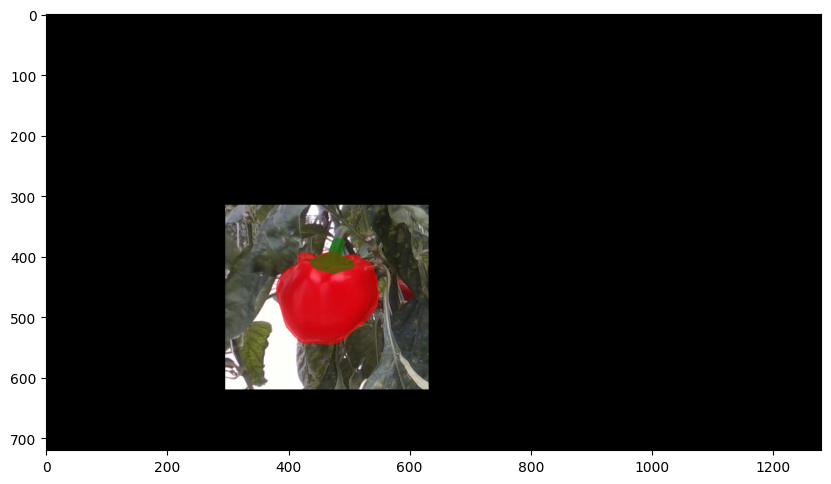

In [30]:
img_path = "/home/kshitij/Documents/Bell Pepper/dataset-collection/dataset_620_red_yellow_cart_only/_Color_1607625615060.01098632812500.png"
image = plt.imread(img_path)
annotation_path = "/home/kshitij/Documents/Bell Pepper/dataset-collection/labels/_Color_1607625615060.01098632812500.txt"

yolo_annotations = open(annotation_path).read()

fig, ax = plt.subplots(figsize=(10,10))

height = image.shape[0]
width = image.shape[1]

image_shape = np.array([width, height]).reshape((-1,2))

annotation_poly = []
fruit_poly = []
peduncle_poly = []

for line in yolo_annotations.split("\n"):
    # y = np.array(line.split(" ")[1:]).astype(np.float32)
    if line.split(" ")[0] == '0':
        fruit_y = np.array(line.split(" ")[1:]).astype(np.float32)
        fruit_poly.append(fruit_y)
    if line.split(" ")[0] == '1':
        peduncle_y = np.array(line.split(" ")[1:]).astype(np.float32)
        peduncle_poly.append(peduncle_y)
    # annotation_poly.append(y)



# Create bounding box around the polygon of object 0. 

for poly in fruit_poly[2:3]:
    x_coords = poly.reshape((-1,2))[:, 0] * width
    y_coords = poly.reshape((-1,2))[:, 1] * height

    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    y_min = np.min(y_coords)
    y_max = np.max(y_coords)

    roi_y_min = (y_min - (y_max - y_min)//2).astype(np.int32)
    roi_y_max = (y_max + (y_max - y_min)//2).astype(np.int32)
    roi_x_min = (x_min - (x_max - x_min)//2).astype(np.int32)
    roi_x_max = (x_max + (x_max - x_min)//2).astype(np.int32)

    # Mask all pixels outside the bounding box
    masked_image = image.copy()
    masked_image[:roi_y_min, :, :] = 0
    masked_image[roi_y_max:, :, :] = 0
    masked_image[:, :roi_x_min, :] = 0
    masked_image[:, roi_x_max:, :] = 0

    # Create a rectangle patch
    # rect = plt.Rectangle((x_min - (x_max - x_min)/2, y_min - (y_max - y_min)/2), 2*(x_max - x_min), 2*(y_max - y_min),
    #                      linewidth=2, edgecolor='blue', facecolor='none')
    
    # # Add the rectangle to the axes
    # ax.add_patch(rect)

# plot the image with polygons and bounding boxes
# plt.show()
ax.imshow(masked_image)
for poly in fruit_poly[2:3]:
    p = Polygon(poly.reshape((-1,2)) * image_shape, facecolor = 'red', edgecolor = 'r',  fill = True, alpha=0.5)
    ax.add_patch(p)



for poly in peduncle_poly:
    scaled_poly = poly.reshape((-1,2)) * image_shape
    p = Polygon(scaled_poly, facecolor = 'green', edgecolor = 'g',  fill = True, alpha=0.5)

    if (scaled_poly[:, 0].min() >= roi_x_min and scaled_poly[:, 0].max() <= roi_x_max and
        scaled_poly[:, 1].min() >= roi_y_min and scaled_poly[:, 1].max() <= roi_y_max):
        ax.add_patch(p)

